# Аналитика данных проекта ResumeMatcher

Этот ноутбук выполняет базовый анализ данных:
- Обзор: размеры, распределения, топ навыков
- Пересечения навыков кандидатов и требований вакансий
- Распределение лейблов, динамика по времени


In [23]:
# Установка зависимостей (выполните один раз)

try:
    import pandas as pd
    import numpy as np
    import sqlalchemy
    import seaborn as sns
    import matplotlib.pyplot as plt
    from dotenv import load_dotenv
except ImportError:
    !pip install pandas numpy sqlalchemy psycopg2-binary seaborn matplotlib python-dotenv --quiet
    import pandas as pd
    import numpy as np
    import sqlalchemy
    import seaborn as sns
    import matplotlib.pyplot as plt
    from dotenv import load_dotenv

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
print("OK: библиотеки готовы")

OK: библиотеки готовы


## Загрузка данных
Загружаем DataFrame-ы кандидатов, вакансий и лейблов. Колонки ожидаются по моделям:
- candidate: `full_name`, `contact_email`, `location`, `years_exp`, `skills_json`, `resume_file_id`, `created_at`
- vacancy: `title`, `location`, `skills_req_json`, `jd_file_id`, `jd_text`, `created_at`
- label: `vacancy_id`, `candidate_id`, `label`, `reason`, `created_at`

In [26]:

import json
from pathlib import Path

base_dir = Path(".")
data_dir = base_dir / "data"

def parse_json_list(x):
    if isinstance(x, list):
        return x
    if pd.isna(x):
        return []
    try:
        return json.loads(x)
    except Exception:
        return []

def read_csv_safe(path):
    try:
        return pd.read_csv(path, encoding="utf-8")
    except FileNotFoundError:
        print(f"Файл не найден: {path}")
        return pd.DataFrame()
    except Exception as e:
        print(f"Не удалось прочитать {path}: {e}")
        return pd.DataFrame()


ct_train = read_csv_safe(data_dir / "candidates_train.csv")
ct_test  = read_csv_safe(data_dir / "candidates_test.csv")

if not ct_train.empty or not ct_test.empty:
    df_candidates = pd.concat([ct_train, ct_test], ignore_index=True)
else:
    df_candidates = pd.DataFrame()

if not df_candidates.empty:
    if "years_exp" in df_candidates.columns:
        df_candidates["years_exp"] = pd.to_numeric(df_candidates["years_exp"], errors="coerce")
    if "skills_json" in df_candidates.columns:
        df_candidates["skills_json"] = df_candidates["skills_json"].apply(parse_json_list)

vt_train = read_csv_safe(data_dir / "vacancies_train.csv")
vt_test  = read_csv_safe(data_dir / "vacancies_test.csv")

if not vt_train.empty or not vt_test.empty:
    df_vacancies = pd.concat([vt_train, vt_test], ignore_index=True)
else:
    df_vacancies = pd.DataFrame()

if not df_vacancies.empty and "skills_req_json" in df_vacancies.columns:
    df_vacancies["skills_req_json"] = df_vacancies["skills_req_json"].apply(parse_json_list)

lt_train = read_csv_safe(data_dir / "labels_train.csv")
lt_test  = read_csv_safe(data_dir / "labels_test.csv")

if not lt_train.empty or not lt_test.empty:
    df_labels = pd.concat([lt_train, lt_test], ignore_index=True)
else:
    df_labels = pd.DataFrame()

print("Загружено из CSV:")
print("Кандидаты:", df_candidates.shape)
print("Вакансии:", df_vacancies.shape)
print("Лейблы:", df_labels.shape)


Загружено из CSV:
Кандидаты: (160, 7)
Вакансии: (80, 6)
Лейблы: (121, 4)


## Базовый обзор и распределения


— Размеры —
Кандидаты: 160
Вакансии: 80
Лейблы: 121


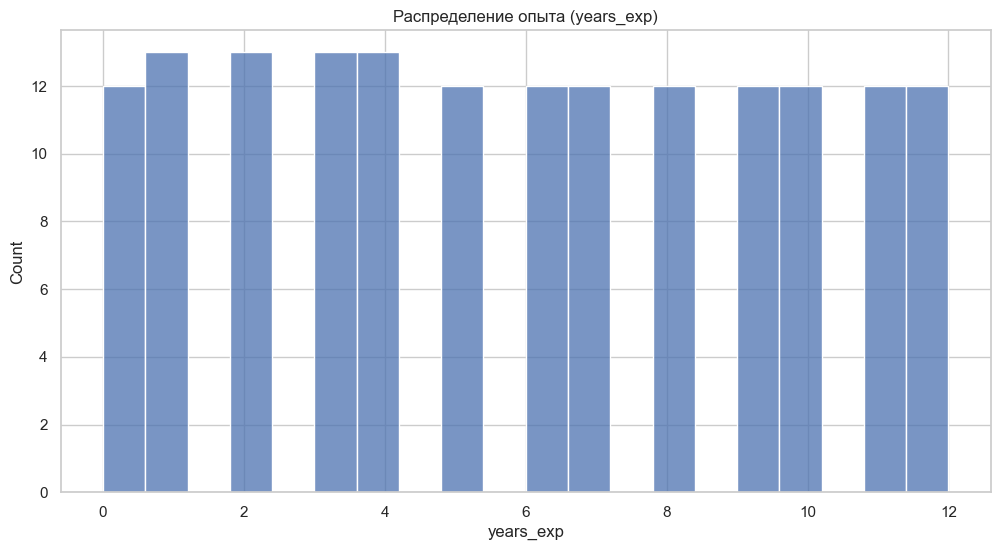

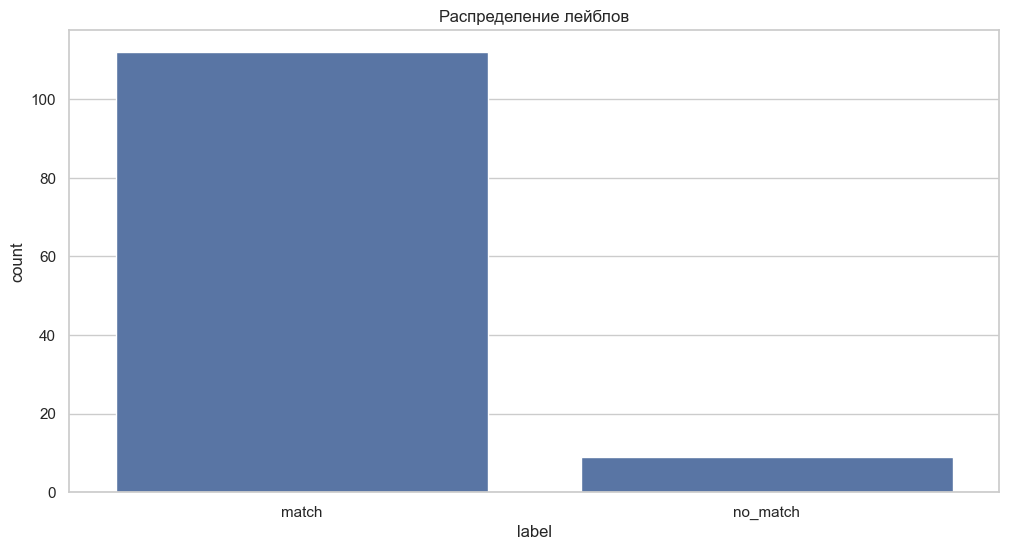

In [12]:
# Подготовка: нормализуем даты и JSON-колонки навыков
def normalize_datetime(df: pd.DataFrame, col: str) -> pd.DataFrame:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')
    return df

def ensure_list(x):
    if isinstance(x, list):
        return x
    if pd.isna(x):
        return []
    # если строка JSON
    try:
        import json
        return json.loads(x)
    except Exception:
        return []

if not df_candidates.empty:
    df_candidates = normalize_datetime(df_candidates, "created_at")
    if "skills_json" in df_candidates.columns:
        df_candidates["skills_json"] = df_candidates["skills_json"].apply(ensure_list)

if not df_vacancies.empty:
    df_vacancies = normalize_datetime(df_vacancies, "created_at")
    if "skills_req_json" in df_vacancies.columns:
        df_vacancies["skills_req_json"] = df_vacancies["skills_req_json"].apply(ensure_list)

if not df_labels.empty:
    df_labels = normalize_datetime(df_labels, "created_at")

print("\n— Размеры —")
print("Кандидаты:", len(df_candidates))
print("Вакансии:", len(df_vacancies))
print("Лейблы:", len(df_labels))

if "years_exp" in df_candidates.columns and not df_candidates.empty:
    sns.histplot(df_candidates["years_exp"].dropna(), bins=20)
    plt.title("Распределение опыта (years_exp)")
    plt.show()

if "created_at" in df_candidates.columns and not df_candidates.empty:
    ts_c = df_candidates.dropna(subset=["created_at"]).set_index("created_at").resample("W").size()
    ts_c.plot()
    plt.title("Динамика добавления кандидатов по неделям")
    plt.show()

if "created_at" in df_vacancies.columns and not df_vacancies.empty:
    ts_v = df_vacancies.dropna(subset=["created_at"]).set_index("created_at").resample("W").size()
    ts_v.plot(color='orange')
    plt.title("Динамика добавления вакансий по неделям")
    plt.show()

if "label" in df_labels.columns and not df_labels.empty:
    sns.countplot(x=df_labels["label"].astype(str))
    plt.title("Распределение лейблов")
    plt.show()

## Навыки: топы и пересечения
Разворачиваем списки навыков у кандидатов и требований у вакансий, смотрим топы и пересечения.

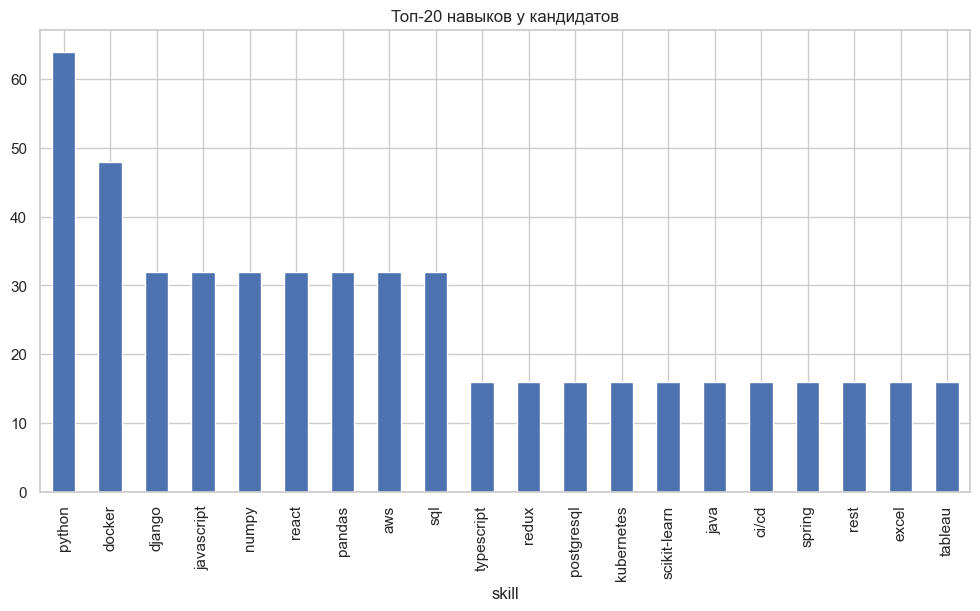

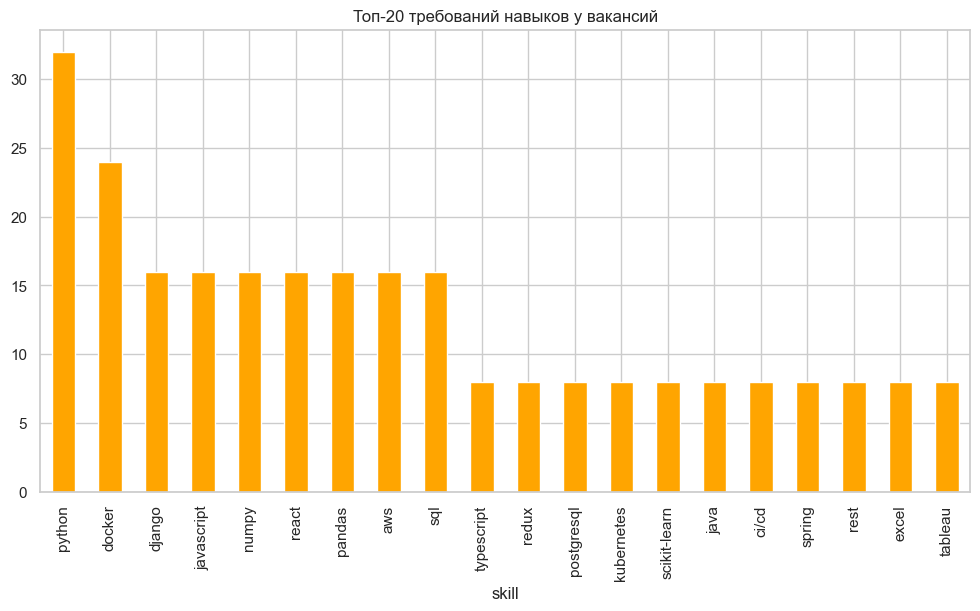

Навыки пересечения (кол-во=28):
['aws', 'ci/cd', 'css', 'data processing', 'django', 'docker', 'excel', 'fastapi', 'java', 'javascript', 'kubernetes', 'linux', 'ml', 'numpy', 'pandas', 'postgresql', 'python', 'react', 'redis', 'redux', 'rest', 'scikit-learn', 'spring', 'sql', 'tableau', 'terraform', 'typescript', 'webpack']


In [13]:
def explode_skills(df: pd.DataFrame, col: str, id_col: str) -> pd.DataFrame:
    if df.empty or col not in df.columns:
        return pd.DataFrame(columns=[id_col, "skill"])    
    work = df[[id_col, col]].copy()
    work[col] = work[col].apply(lambda xs: xs if isinstance(xs, list) else [])
    ex = work.explode(col)
    ex = ex.rename(columns={col: "skill"})
    ex = ex.dropna(subset=["skill"]).assign(skill=lambda s: s["skill"].astype(str).str.strip().str.lower())
    ex = ex[ex["skill"] != ""]
    return ex

cand_skills = explode_skills(df_candidates, "skills_json", id_col=df_candidates.columns[0] if not df_candidates.empty else "id")
vac_skills = explode_skills(df_vacancies, "skills_req_json", id_col=df_vacancies.columns[0] if not df_vacancies.empty else "id")

if not cand_skills.empty:
    top_c = cand_skills["skill"].value_counts().head(20)
    top_c.plot(kind='bar')
    plt.title("Топ-20 навыков у кандидатов")
    plt.show()
else:
    print("Нет данных по навыкам кандидатов.")

if not vac_skills.empty:
    top_v = vac_skills["skill"].value_counts().head(20)
    top_v.plot(kind='bar', color='orange')
    plt.title("Топ-20 требований навыков у вакансий")
    plt.show()
else:
    print("Нет данных по требованиям навыков у вакансий.")

# Пересечение навыков: какие навыки часто есть у кандидатов и встречаются в требованиях
if not cand_skills.empty and not vac_skills.empty:
    cand_set = set(cand_skills["skill"].unique())
    vac_set = set(vac_skills["skill"].unique())
    inter = sorted(cand_set & vac_set)
    print(f"Навыки пересечения (кол-во={len(inter)}):")
    print(inter[:100])
else:
    print("Недостаточно данных для пересечения навыков.")

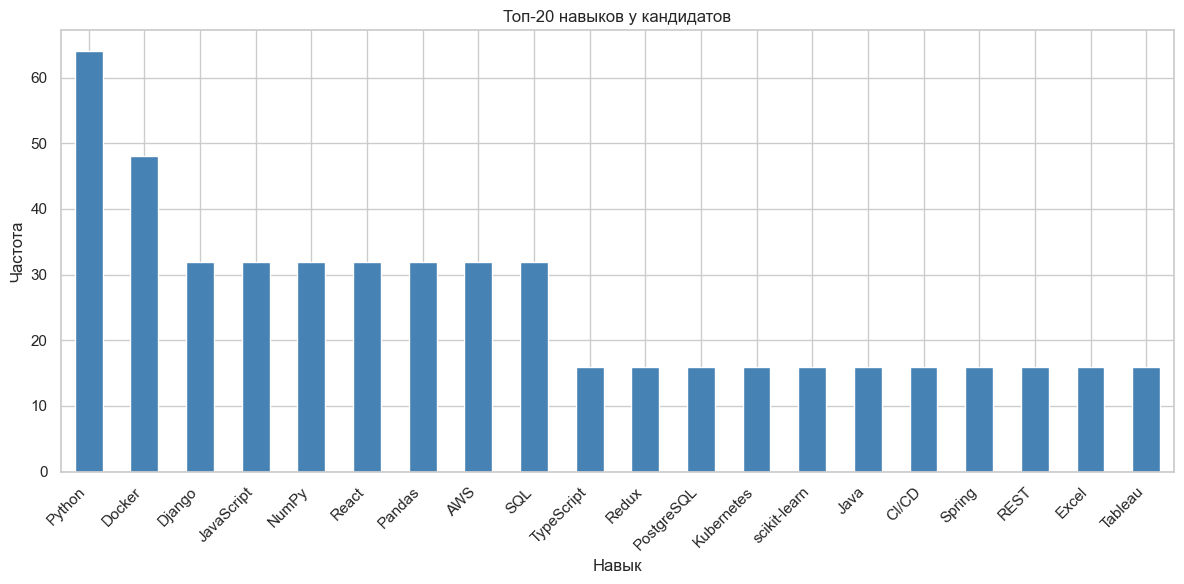

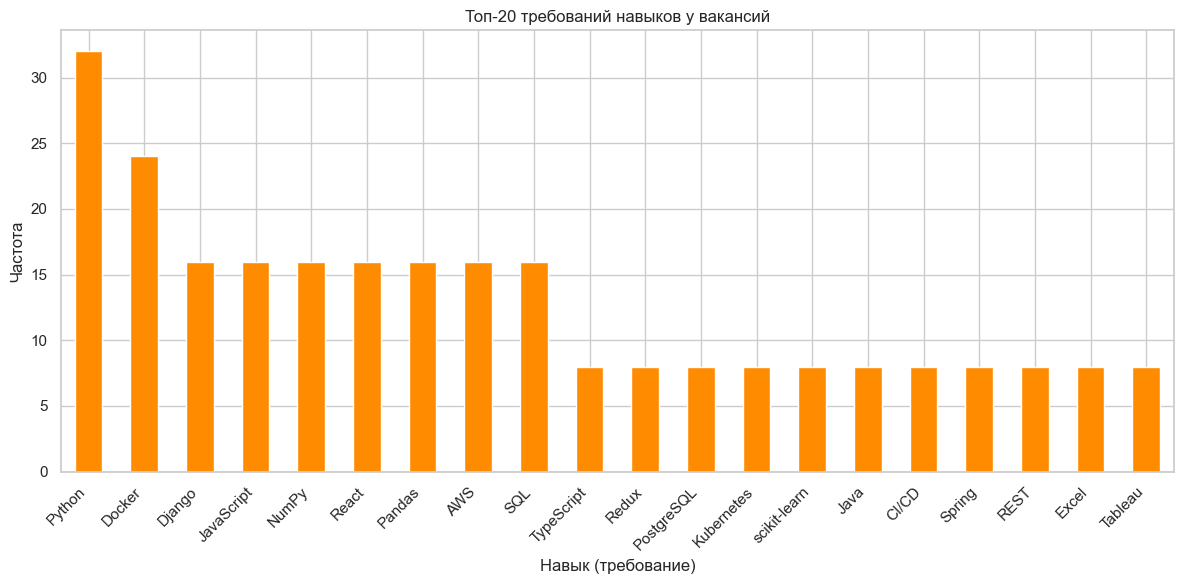

<Figure size 1200x600 with 0 Axes>

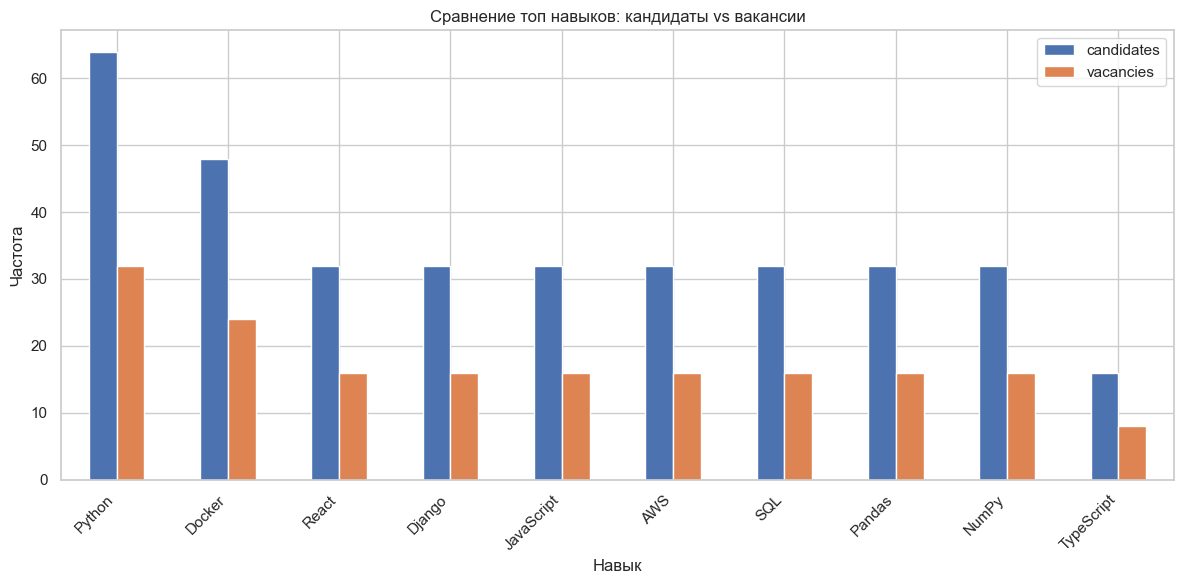

In [17]:

def explode_skills_simple(df: pd.DataFrame, col: str, id_col: str) -> pd.DataFrame:
    if df.empty or col not in df.columns:
        return pd.DataFrame(columns=[id_col, "skill"])
    work = df[[id_col, col]].copy()
    work[col] = work[col].apply(lambda xs: xs if isinstance(xs, list) else [])
    ex = work.explode(col)
    ex = ex.rename(columns={col: "skill"})
    ex = ex.dropna(subset=["skill"]).assign(skill=lambda s: s["skill"].astype(str).str.strip())
    ex = ex[ex["skill"] != ""]
    return ex

# Кандидаты: топ-20 навыков
if not df_candidates.empty and "skills_json" in df_candidates.columns:
    cand_id_col = "id" if "id" in df_candidates.columns else df_candidates.columns[0]
    cand_skills = explode_skills_simple(df_candidates, "skills_json", cand_id_col)
    if not cand_skills.empty:
        top20_cand = cand_skills["skill"].value_counts().head(20)
        plt.figure()
        top20_cand.plot(kind="bar", color="steelblue")
        plt.xlabel("Навык")
        plt.ylabel("Частота")
        plt.title("Топ-20 навыков у кандидатов")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()
    else:
        print("Нет развернутых навыков кандидатов для графика.")

# Вакансии: топ-20 требований
if not df_vacancies.empty and "skills_req_json" in df_vacancies.columns:
    vac_id_col = "id" if "id" in df_vacancies.columns else df_vacancies.columns[0]
    vac_skills = explode_skills_simple(df_vacancies, "skills_req_json", vac_id_col)
    if not vac_skills.empty:
        top20_vac = vac_skills["skill"].value_counts().head(20)
        plt.figure()
        top20_vac.plot(kind="bar", color="darkorange")
        plt.xlabel("Навык (требование)")
        plt.ylabel("Частота")
        plt.title("Топ-20 требований навыков у вакансий")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()
    else:
        print("Нет развернутых требований навыков у вакансий для графика.")

# Сравнение топ-10: кандидаты vs вакансии
if not df_candidates.empty and not df_vacancies.empty:
    if "skills_json" in df_candidates.columns and "skills_req_json" in df_vacancies.columns:
        top10_c = cand_skills["skill"].value_counts().head(10) if not cand_skills.empty else pd.Series(dtype=int)
        top10_v = vac_skills["skill"].value_counts().head(10) if not vac_skills.empty else pd.Series(dtype=int)
        common = set(top10_c.index) | set(top10_v.index)
        comp_df = pd.DataFrame({
            "candidates": [top10_c.get(k, 0) for k in common],
            "vacancies": [top10_v.get(k, 0) for k in common]
        }, index=list(common)).sort_values(by="candidates", ascending=False)
        plt.figure()
        comp_df.plot(kind="bar")
        plt.xlabel("Навык")
        plt.ylabel("Частота")
        plt.title("Сравнение топ навыков: кандидаты vs вакансии")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()


## Лейблы и причины
Если разметка присутствует, смотрим распределение причин (если заполнены).

In [18]:
if not df_labels.empty and "reason" in df_labels.columns:
    reasons = df_labels["reason"].dropna().astype(str)
    print("Пример причин (до 10):")
    display(reasons.head(10))
else:
    print("Нет колонок 'reason' или лейблов для анализа причин.")

Пример причин (до 10):


0    Совпадение навыков: 3; опыт 1 лет.
1    Совпадение навыков: 2; опыт 7 лет.
2    Совпадение навыков: 3; опыт 2 лет.
3    Совпадение навыков: 3; опыт 3 лет.
4    Совпадение навыков: 3; опыт 4 лет.
5    Совпадение навыков: 3; опыт 5 лет.
6    Совпадение навыков: 3; опыт 6 лет.
7    Совпадение навыков: 3; опыт 7 лет.
8    Совпадение навыков: 3; опыт 8 лет.
9    Совпадение навыков: 3; опыт 9 лет.
Name: reason, dtype: object

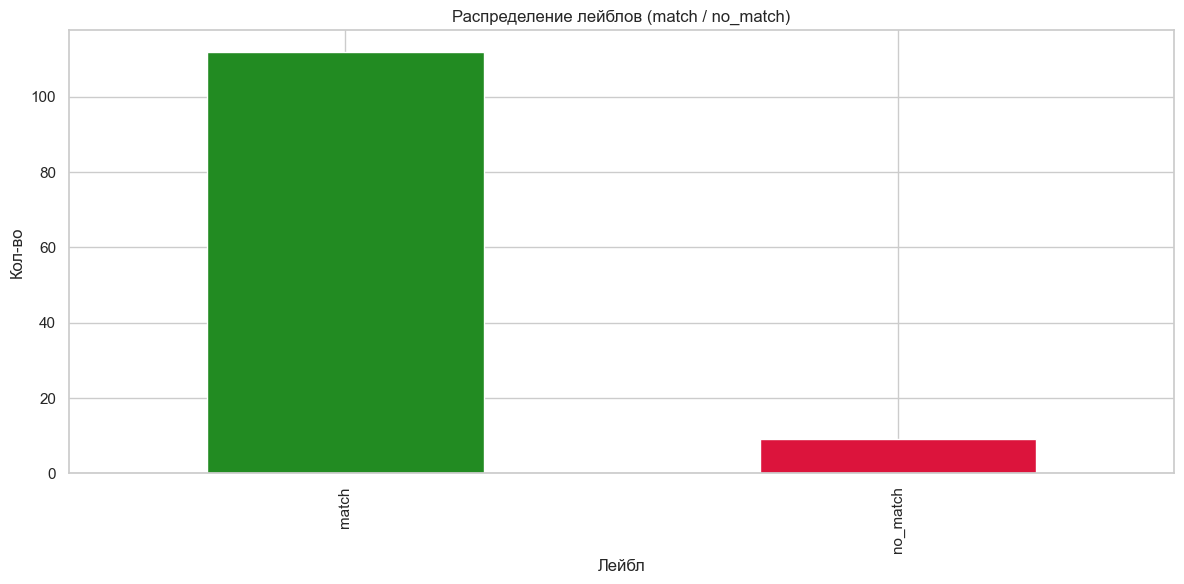

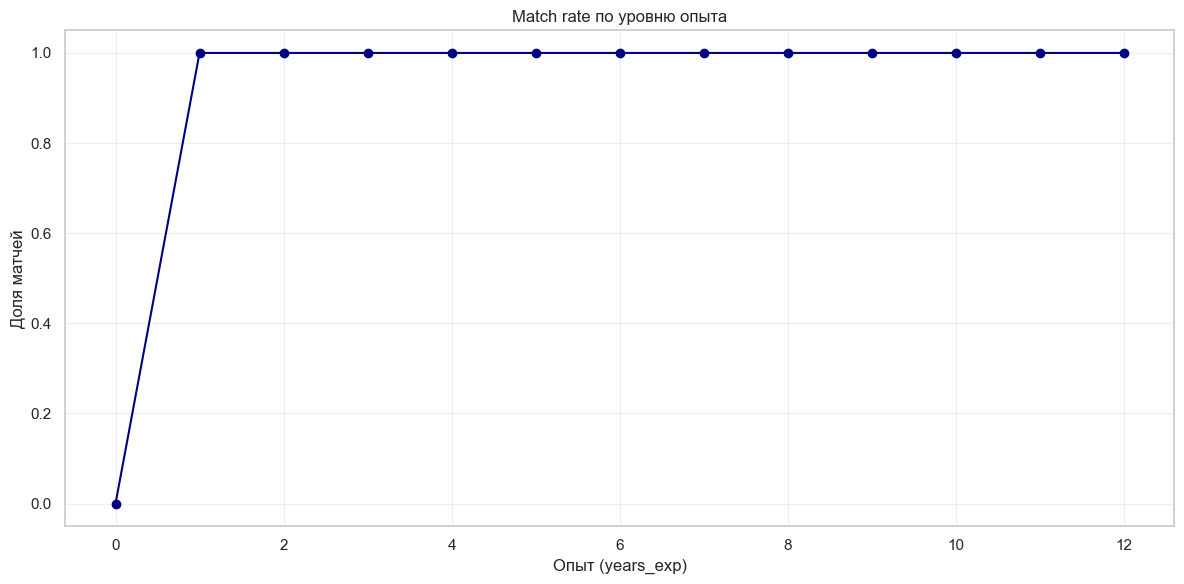

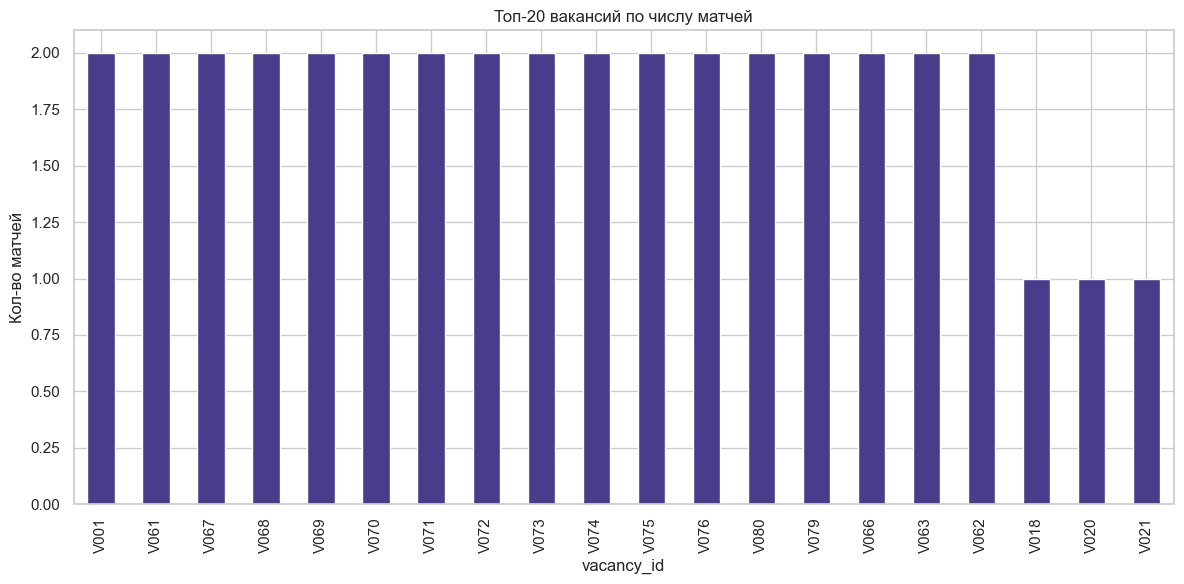

In [19]:

if not df_labels.empty:
    label_counts = df_labels["label"].astype(str).value_counts()
    plt.figure()
    label_counts.plot(
        kind="bar",
        color=["forestgreen" if k == "match" else "crimson" for k in label_counts.index]
    )
    plt.xlabel("Лейбл")
    plt.ylabel("Кол-во")
    plt.title("Распределение лейблов (match / no_match)")
    plt.tight_layout()
    plt.show()

    if "candidate_id" in df_labels.columns:
        cid_col = "id" if "id" in df_candidates.columns else df_candidates.columns[0]
        if cid_col in df_candidates.columns:
            m = df_labels.merge(
                df_candidates[[cid_col, "years_exp"]],
                left_on="candidate_id",
                right_on=cid_col,
                how="left",
            )
            m["is_match"] = (m["label"].astype(str) == "match").astype(int)
            grp = m.groupby("years_exp", dropna=True)["is_match"].mean().sort_index()
            plt.figure()
            plt.plot(grp.index, grp.values, marker="o", color="navy")
            plt.xlabel("Опыт (years_exp)")
            plt.ylabel("Доля матчей")
            plt.title("Match rate по уровню опыта")
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()

    vac_match_counts = df_labels.assign(
        is_match=(df_labels["label"].astype(str) == "match").astype(int)
    )
    vac_agg = (
        vac_match_counts.groupby("vacancy_id")["is_match"]
        .sum()
        .sort_values(ascending=False)
        .head(20)
    )
    plt.figure()
    vac_agg.plot(kind="bar", color="darkslateblue")
    plt.xlabel("vacancy_id")
    plt.ylabel("Кол-во матчей")
    plt.title("Топ-20 вакансий по числу матчей")
    plt.tight_layout()
    plt.show()
else:
    print("Нет данных лейблов для построения графиков.")


## Сводка по качеству данных и рекомендациям
- Проверьте, что заполнены ключевые поля: `years_exp`, `skills_json` у кандидатов; `skills_req_json` у вакансий; `label`/`reason` у разметки.
- Если данные пустые — сначала прогоните импорт/пайплайн, чтобы создать таблицы и записи.
- Для локального запуска используйте значения из `deploy/.env.example` или `.env`.
